(48, 48, 1)

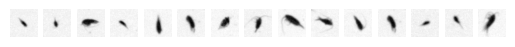

In [133]:
import deeptrack as dt
import numpy as np
from matplotlib import pyplot as plt
import cv2

image = dt.LoadImage("copepod_images/cope_1.png")
image = np.array(image.resolve())

#Some single copepod positions from cope_1.png, additional crops are commented out.
ys    = [1875,    1487,  955,1740,2693,2955,1430,1970,2537  ,1945,1480,2955,2345,1864,3087] #1525,
xs    = [1785,   1550,   2050,1825,2010,2040,2395,850,1482,1230,1595,2040, 1070, 920, 1773] #1517,

training_images = []
number_of_crops = len(ys)

for i in range(number_of_crops):
    #go through the positions for the crops
    y_index   = ys[i]
    x_index   = xs[i]
    crop_size = 48
    x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
    training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])
    training_image = cv2.cvtColor(training_image,cv2.COLOR_BGR2GRAY)
    training_image = np.expand_dims(training_image,axis=-1)
    training_images.append(training_image)
    plt.subplot(1,number_of_crops,i+1)
    plt.axis("off")
    plt.imshow(training_image,cmap="gray")
np.shape(training_image)



# Defining the Variational Autoencoder

In [162]:


import deeplay as dl 
from deeplay.components import ConvolutionalEncoder2d
import torch

channel_param = [64,128]
vae = dl.VariationalAutoEncoder(
    input_size = (48,48,1),
  
    latent_dim = 2,
    channels   =channel_param,
    #encoder = ConvolutionalEncoder2d(2,channel_param,channel_param[-1]),
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"),
    beta = 1,
).create()
print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=18432, o

# Training Pipeline

In [163]:
from torch.utils.data import DataLoader
import random
random_crop = dt.Value(lambda: random.choice(training_images))
image_pipeline = (
    dt.Value(random_crop)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2,0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

train_dataset = dt.pytorch.Dataset(image_pipeline & image_pipeline,length=100)
train_loader  = DataLoader(train_dataset,batch_size=64,shuffle=True)

# Training

In [164]:
vae_trainer = dl.Trainer(max_epochs=100,accelerator="auto")
vae_trainer.fit(vae,train_loader)

INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 222 K 
1 | fc_mu               | Linear                 | 36.9 K
2 | fc_var              | Linear                 | 36.9 K
3 | fc_dec              | Linear                 | 55.3 K
4 | decoder             | ConvolutionalDecoder2d | 304 K 
5 | reconstruction_loss | BCELoss                | 0     
6 | train_metrics       | MetricCollection       | 0     
7 | val_metrics         | MetricCollection       | 0     
8 | test_metrics        | MetricCollection       | 0     
9 | optimizer           | Adam                   | 0     
---------------------------------------------------------------
655 K     Trainable params
0         Non-trainable params
655 K     Total params
2.621     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name                | Type                   

Epoch 99: 100%|██████████| 2/2 [00:02<00:00,  0.85it/s, v_num=81, train_rec_loss_step=2e+4, train_KL_step=182.0, train_total_loss_step=2.02e+4, train_rec_loss_epoch=2.95e+4, train_KL_epoch=272.0, train_total_loss_epoch=2.98e+4]    


# Sampling Latent space

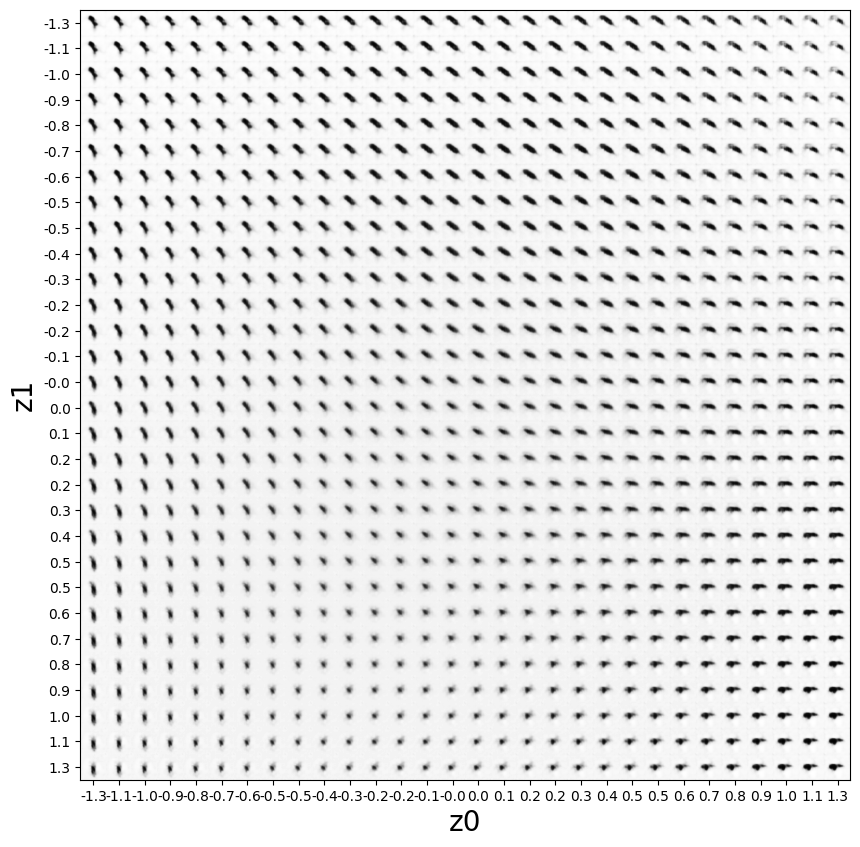

In [165]:
from torch.distributions.normal import Normal
img_num = 30
img_size = 48

z0_grid = Normal(0, 1).icdf(torch.linspace(0.1, 0.9, img_num))
z1_grid = Normal(0, 1).icdf(torch.linspace(0.1, 0.9, img_num))
image = np.zeros((img_num * img_size, img_num * img_size))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z=torch.stack((z0,z1)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach()
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size,
        ] = generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xticks(
np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
np.round(z0_grid.numpy(), 1),
)
plt.yticks(
np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
np.round(z1_grid.numpy(), 1),
)
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show()